
## DESCRIPTION

This notebook fits a Random Survival Forest

***
### SETUP

Load the setup script

In [1]:
from utils.common_setup import *

Import the cleaned dataset

In [2]:
data_folder = os.path.join(os.getcwd(), '..', 'data')
data = pd.read_csv(os.path.join(data_folder, 'clean_data.csv'))

In [3]:
data[['creation_date', 'season_start_month', 'season_start_day', 'death_next_season']]

,creation_date,season_start_month,season_start_day,death_next_season
0,2021-05-19,5,14,False
1,2021-05-08,5,14,False
2,2021-05-17,5,14,False
3,2021-05-25,5,14,False
4,2021-06-05,5,14,False
...,...,...,...,...
112621,2023-08-15,4,1,False
112622,2023-08-16,4,1,False
112623,2023-08-16,4,1,False
112624,2023-08-16,4,1,False


In [4]:
data['season_start_month'].describe()

count    112626.000000
mean          3.480191
std           2.549262
min           1.000000
25%           1.000000
50%           4.000000
75%           7.000000
max           7.000000
Name: season_start_month, dtype: float64

### DEFINE HYPERPARAMETERS

In [5]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1250, num = 10)]
n_estimators = [100, 500, 1000]  # Reduced

# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
#max_depth.append(None)
max_depth = [10, 30, 60]  # Reduced

# Minimum number of samples required to split a node
# min_samples_split = [10, 20, 40, 60]
min_samples_split = [10, 20, 40] # Reduced

# Minimum number of samples required at each leaf node
#min_samples_leaf = [10, 20, 40, 60]
min_samples_leaf = [10, 20, 40] # Reduced

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

### SELECT FEATURES

In [6]:
features = [
    'aqhi_average_og','tavg_average_og'
    ,'wspd_average_og','ndvi_average'
    ,'prcp_average_og'
]

# Features for RSF 1 including region
# Correlated features so not best idea
#features = [
#    'aqhi_average_og', 'tavg_average_og', 'tavg_max', 'tavg_skew'
#    ,'wspd_average_og', 'wspd_skew', 'wspd_max', 'ndvi_skew', 'ndvi_max', 'ndvi_average'
#    ,'prcp_average_og', 'prcp_skew', 'prcp_max'
#]

data.season.value_counts()

2023    84056
2022    22640
2021     5930
Name: season, dtype: int64

Prepare features object

In [8]:
# Drop NAs
X = data.dropna(subset = ['death_next_season', 'hive_age_next_season'], axis = 0)
X.fillna(0, inplace = True)

# Features object
X = X[features]

# One-hot enconding of region and add to features
#gr = pd.get_dummies(data['region'])
#X = pd.concat([X, gr], axis = 1)

# Convert y to boolean
data['death_next_season'] = data['death_next_season'].astype(bool)

#### SPLIT DATA

- Train and test
- Transform

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis = 1)\
        .tolist(), dtype = [('cens', '?'), ('time', '<f8')]),
    test_size = 0.15,
    random_state = 8
)

# Apply min-max transform
mx = StandardScaler()
X_train = mx.fit_transform(X_train)
X_test = mx.transform(X_test)

### FIT THE RANDOM SURVIVAL FOREST

The RSF was fitted on a remote computer cluster with 128G of RAM and 16 cores.

Running this on a personal computer will take a very long time.

Model finishes running after ~10hours on the remote computer.

In [7]:
#rf = RandomSurvivalForest()
#
#rf_random = RandomizedSearchCV(
#    estimator = rf,
#    param_distributions = random_grid,
#    n_iter = 5,
#    cv = 3,
#    verbose = 1,
#    random_state = 8,
#    n_jobs = 16, # change at will but 16 is a good tradeoff between efficiency and RAM usage
#)
#
## Fit the random search model
#rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


Save the best model

In [ ]:
#project_root = os.path.dirname(os.getcwd())
#output_dir = os.path.join(project_root, 'outputs')    
#filename = os.path.join(output_dir, "best_RSF_NoRegion.pkl.pkl")
#
#joblib.dump(rf_random.best_estimator_, filename)

Import best model

In [10]:
import joblib
cluster_job = os.path.join(os.getcwd(), '..', 'cluster_job')
rf_random = joblib.load(os.path.join(cluster_job, 'best_RSF_NoRegion.pkl'))

### PREDICTIONS

In [11]:
preds = rf_random.predict(X_test)

SCORE:
0.83


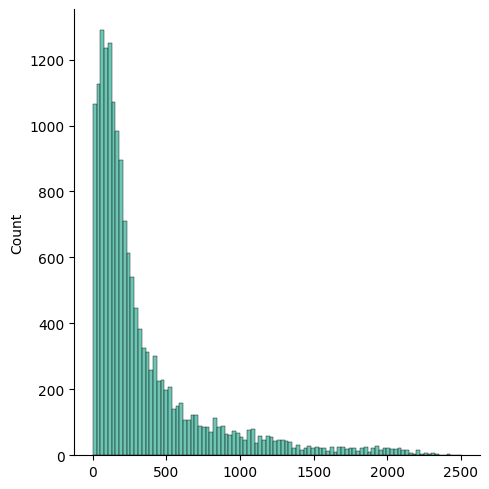

In [15]:
print("SCORE:")
print(round(rf_random.score(X_test, y_test), 2))

sns.displot(preds, color = "#3CB29A")

### EVALUATE FIT

In [12]:
# Time intervals
va_times = np.arange(300, 550, 7)

# Predict cumulative hazard function
rsf_chf_funcs = rf_random.predict_cumulative_hazard_function(
    X_test,
    return_array=False
)

# Predicted risk scores at each time interval using cumulative hazard function
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

# Mean AUC and time-dependent AUC
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train,
    y_test,
    rsf_risk_scores,
    va_times
)

In [18]:
rsf_mean_auc

0.9360965968414312

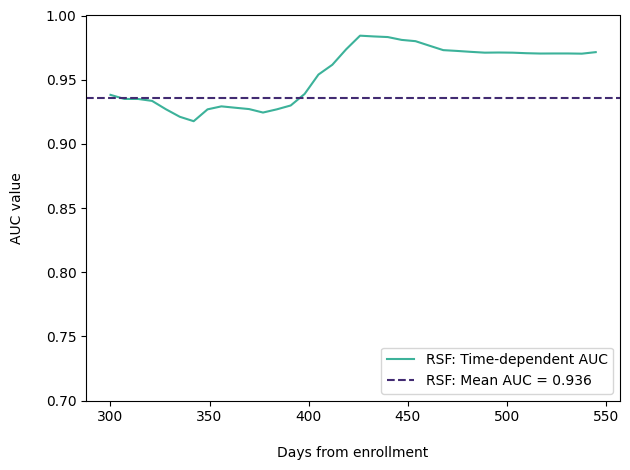

In [61]:
plt.plot(
    va_times,
    rsf_auc,
    "-",
    color = "#3CB29A",
    label = "RSF: Time-dependent AUC"
)

# Add mean AUC
plt.axhline(
    rsf_mean_auc,
    linestyle = "--",
    color = "#422B72",
    label = "RSF: Mean AUC = {:.3f}".format(rsf_mean_auc)
)

# Labels and limits
plt.xlabel("\nDays from enrollment")
plt.ylabel("AUC value\n")
plt.ylim(0.7, 1.0)

# Legend
plt.legend(loc="lower right")

# Remove the grid
plt.grid(False)

# Save
plt.tight_layout()
outputs_folder = os.path.join(os.getcwd(), '..', 'outputs')
plt.savefig(os.path.join(outputs_folder, "RSF_ROC.png"), dpi=500)

# Show plot
plt.show()

### FEATURE IMPORTANCE

Permutation takes a very long time.

Run locally with as many cores as possible with `n_jobs = -1`.

To bypass running, just import the object locally.

In [19]:
#from sklearn.inspection import permutation_importance
#
#result = permutation_importance(
#    rf_random,
#    X_test, y_test,
#    n_repeats = 15,
#    random_state = 8,
#    n_jobs = -1
#)
#
#project_root = os.path.dirname(os.getcwd())
#output_dir = os.path.join(project_root, 'outputs')    
#filename = os.path.join(output_dir, "RSF_NoRegion_FeatImp.pkl")
#
#joblib.dump(result, filename)

Import feature importance object

In [20]:
result = joblib.load(os.path.join(cluster_job, 'RSF_NoRegion_FeatImp.pkl'))

In [109]:
# Add a label column before sorting
df_imp = pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X.columns
)

# Add a label column with custom feature names (before sorting)
df_imp['label'] = ['AQHI', 'Temperature', 'Wind speed', 'NDVI', 'Precipitation']

# Now sort by importance
df_imp = df_imp.sort_values(by="importances_mean", ascending=True)

# View the updated DataFrame
print(df_imp)


                 importances_mean  importances_std          label
ndvi_average             0.023184         0.000920           NDVI
wspd_average_og          0.094808         0.001955     Wind speed
tavg_average_og          0.170749         0.003317    Temperature
aqhi_average_og          0.186231         0.002090           AQHI
prcp_average_og          0.198975         0.002104  Precipitation


#### Plot feature importance

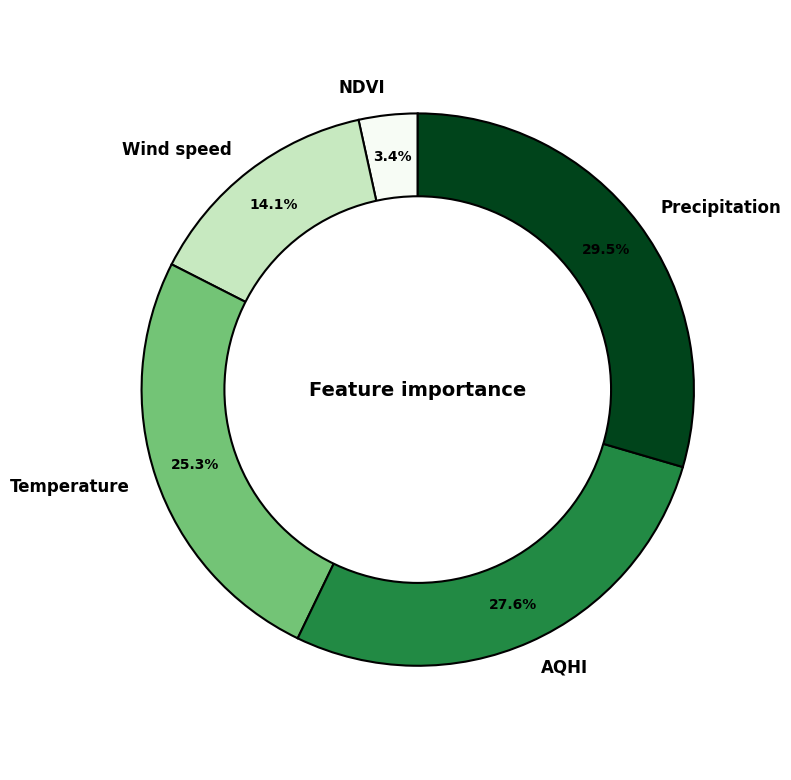

In [110]:
# Values and custom labels
values = df_imp['importances_mean']
labels = df_imp['label']

# Color palette
colors = cm.Greens(np.linspace(0, 1, len(values)))

# Donut chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',  # Percentage display
    startangle=90,      # Start the pie chart at 90 degrees
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  # Edges control
    pctdistance=0.85    # % Inside slices
)

# Add a circle at the center for donut effect
center_circle = plt.Circle((0, 0), 0.70, fc='white', edgecolor='black', lw=1.5)
fig.gca().add_artist(center_circle)

# Aspect ratio
plt.axis('equal')

# Percentage labels inside color bars
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

# Feature labels text
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')

# Title in the middle
plt.text(0, 0, 'Feature importance', ha='center', va='center', fontsize=14, weight='bold')

# Save plot
plt.tight_layout()
outputs_folder = os.path.join(os.getcwd(), '..', 'outputs')
plt.savefig(os.path.join(outputs_folder, "RSF_NoRegion_FeatImp.png"), dpi=500)

# Show plot
plt.show()

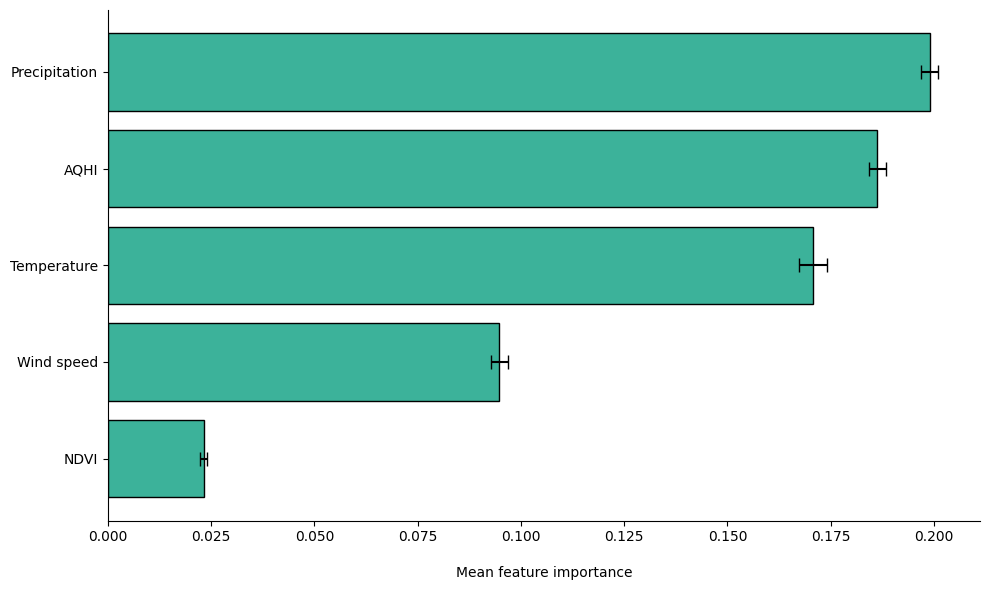

In [118]:

values = df_imp['importances_mean']
errors = df_imp['importances_std']
labels = df_imp['label']

# Create barplot
plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

plt.barh(labels, values, xerr=errors, color='#3CB29A', edgecolor='black', capsize=5)

# Add labels and title
plt.xlabel("\nMean feature importance")
plt.ylabel("")

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save plot
outputs_folder = os.path.join(os.getcwd(), '..', 'outputs')
plt.savefig(os.path.join(outputs_folder, "RSF_NoRegion_FeatImp2.png"), dpi=500)

# Show plot
plt.show()